# Explora aquí

Se recomienda utilizar este cuaderno con fines de exploración.

In [221]:
import pandas as pd
import sqlite3
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import io

url = "https://en.wikipedia.org/wiki/List_of_highest-grossing_films"
response = requests.get(url)
# Verificamos la respuesta
print("Estado:", response.status_code)



Estado: 200


In [222]:
# Modelo para Extraer las tablas

html = io.StringIO(response.text)
tables = pd.read_html(html)
print(f"Se encontraron {len(tables)} tablas.")

Se encontraron 89 tablas.


In [223]:
df = tables[0]
df.head()  

,Rank,Peak,Title,Worldwide gross,Year,Ref
0,1,1,Avatar,"$2,923,706,026",2009,[# 1][# 2]
1,2,1,Avengers: Endgame,"$2,797,501,328",2019,[# 3][# 4]
2,3,3,Avatar: The Way of Water,"$2,320,250,281",2022,[# 5][# 6]
3,4,1,Titanic,"T$2,257,844,554",1997,[# 7][# 8]
4,5,5,Ne Zha 2 †,"$2,212,290,000",2025,[# 9][# 10]


In [224]:
df = tables[1]
df.head()  

,Rank,Title,Worldwide gross (2023 $),Year
0,1,Gone with the Wind,"GW$4,341,000,000",1939
1,2,Avatar,"A1$3,957,000,000",2009
2,3,Titanic,"T$3,677,000,000",1997
3,4,Star Wars,"$3,563,000,000",1977
4,5,Avengers: Endgame,"AE$3,275,000,000",2019


In [225]:
df = tables[2]
df.head()  

,Year,Title,Worldwide gross,Budget,Ref
0,1915,The Birth of a Nation,"$50,000,000–100,000,000 $20,000,000+R ($5,200,...","$110,000",[# 85][# 86][# 87]
1,1916,Intolerance,"$1,750,000R IN","$385,907",[52][53]
2,1917,Cleopatra,"$500,000*R","$300,000",[# 88][# 89]
3,1918,Mickey,"$8,000,000","$250,000",[# 90]
4,1919,The Miracle Man,"$3,000,000R","$120,000",[# 91]


In [226]:
df = tables[3]
df.head()  

,Established,Title,Record-setting gross,Ref
0,1915[66],The Birth of a Nation,"$5,200,000R",[# 86]
1,1940,The Birth of a Nation,"$15,000,000R ‡",[# 314]
2,1940[32],Gone with the Wind,"$32,000,000R",[# 137]
3,1963,Gone with the Wind,"$67,000,000R ‡",[# 315]
4,1966[66],The Sound of Music,"$114,600,000R",[# 211]


## Voy a Tomar la Tabla 1

In [227]:
df = tables[0]
df.head()  

,Rank,Peak,Title,Worldwide gross,Year,Ref
0,1,1,Avatar,"$2,923,706,026",2009,[# 1][# 2]
1,2,1,Avengers: Endgame,"$2,797,501,328",2019,[# 3][# 4]
2,3,3,Avatar: The Way of Water,"$2,320,250,281",2022,[# 5][# 6]
3,4,1,Titanic,"T$2,257,844,554",1997,[# 7][# 8]
4,5,5,Ne Zha 2 †,"$2,212,290,000",2025,[# 9][# 10]


## Procesar datos

In [ ]:

# Eliminamos notas entre corchetes
df["Title"] = df["Title"].str.replace(r"\[.*?\]", "", regex=True)
df["Wgross"]=df["Worldwide gross"]
#del df["Worldwide gross"]

df["Wgross"] = df["Wgross"].replace(r'^.*?\$', '', regex=True)  # Elimina todo lo que no sea número, coma o punto
df["Wgross"] = df["Wgross"].str.replace(",", "")

# Paso 3: Convertir a número (float), convirtiendo errores a NaN
df["Wgross"] = pd.to_numeric(df["Wgross"], errors="coerce")

df.head()


,Rank,Peak,Title,Worldwide gross,Year,Ref,Wgross
0,1,1,Avatar,"$2,923,706,026",2009,[# 1][# 2],2923706026
1,2,1,Avengers: Endgame,"$2,797,501,328",2019,[# 3][# 4],2797501328
2,3,3,Avatar: The Way of Water,"$2,320,250,281",2022,[# 5][# 6],2320250281
3,4,1,Titanic,"T$2,257,844,554",1997,[# 7][# 8],2257844554
4,5,5,Ne Zha 2 †,"$2,212,290,000",2025,[# 9][# 10],2212290000
5,6,3,Star Wars: The Force Awakens,"$2,068,223,624",2015,[# 11][# 12],2068223624
6,7,4,Avengers: Infinity War,"$2,048,359,754",2018,[# 13][# 14],2048359754
7,8,6,Spider-Man: No Way Home,"SM$1,922,598,800",2021,[# 15][# 16],1922598800
8,9,8,Inside Out 2,"$1,698,863,816",2024,[# 17][# 18],1698863816
9,10,3,Jurassic World,"$1,671,537,444",2015,[# 19][# 20],1671537444


In [229]:
#del df["Worldwide gross"]
del df["Worldwide gross"]

## Escritura en SQLite

In [230]:
# Creo la Base De Datos
conn = sqlite3.connect("top_gross_movies.db")

In [231]:
# Create table in SQLite
df.to_sql("top_gross", conn, if_exists="replace", index=False)
cursor = conn.cursor()

In [232]:
# Insert data into the database
cursor.execute("SELECT COUNT(*) FROM top_gross")
print("Rows inserted:", cursor.fetchone()[0])

conn.commit()
conn.close()

Rows inserted: 50


Visualizacion Datos

In [233]:
print(df["Wgross"].dtype)

int64


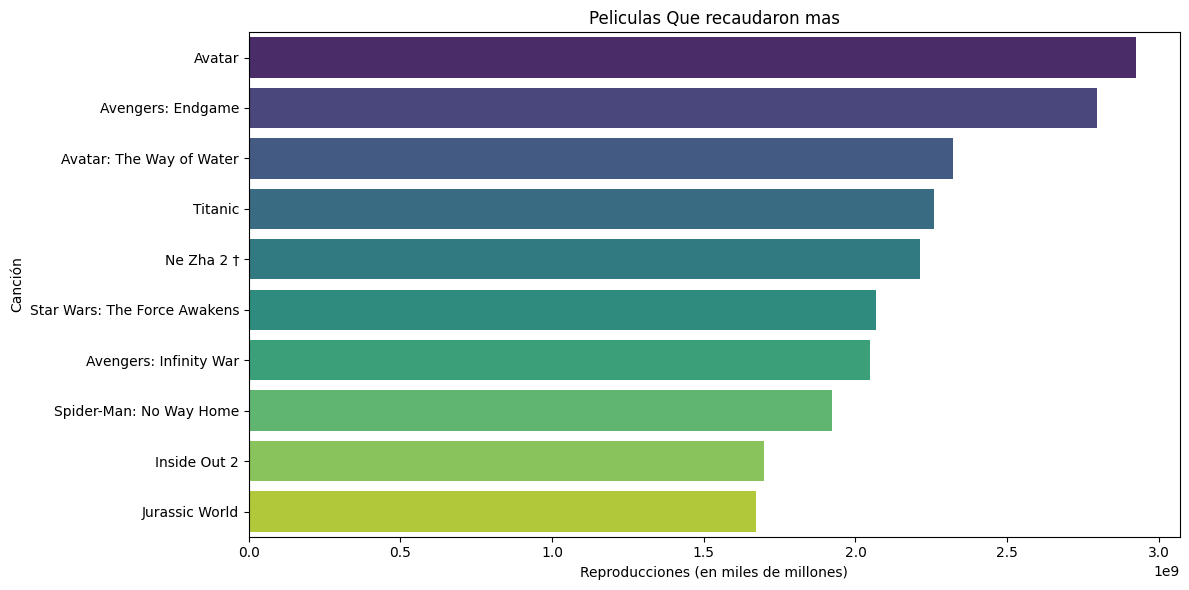

In [234]:

top10 = df.nlargest(10, "Wgross")
plt.figure(figsize=(12, 6))
sns.barplot(data=top10, x="Wgross", y="Title", hue="Title", palette="viridis", legend=False)
plt.title("Peliculas Que recaudaron mas")
plt.xlabel("Reproducciones (en miles de millones)")
plt.ylabel("Canción")
plt.tight_layout()
plt.show()